<a href="https://colab.research.google.com/github/nghess/micrograd/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [437]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline

In [438]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):  # if other * self
    return self * other

  def __radd__(self, other):  # if other + self
    return self + other

  def __truediv__(self, other):  # self / other
    return self * other**-1

  def __neg__(self):  # -self
    return self * -1

  def __sub__(self, other):  # self - other
    return self + (-other)

  def __pow__(self, other):  # self ** other
    assert isinstance(other, (int, float))
    out = Value(self.data ** other, (self,), f"**{other}")
    
    def _backward():
      self.grad += (other * self.data ** (other-1)) * out.grad
    out._backward = _backward
    return out


  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad = out.data * out.grad
    out._backward = _backward
    return out
  
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [439]:
# Graph visiualization

def trace(root):
  # Builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation,  create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this not to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

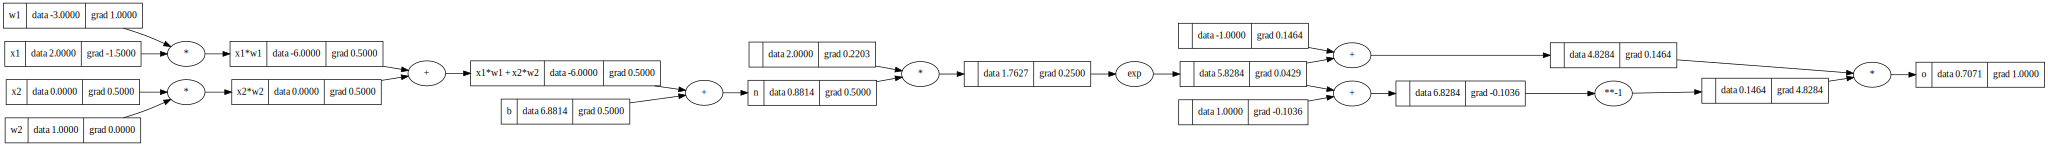

In [440]:
# Single neuron example

# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813725870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label= 'x1*w1'
x2w2 = x2*w2; x2w2.label= 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# Tanh
e = (2*n).exp()
o = (e - 1) / (e + 1)

# Automated backprop
o.label = 'o'
o.backward()
# Draw graph
draw_dot(o)

In [441]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w = x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [442]:
# Define network architecture
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])  #3x input to 4x layer to 4x layer to 1x output
n(x)

Value(data=-0.936018360299986)

In [443]:
# Training Data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

# Desired targets
ys = [1.0, -1.0, -1.0, 1] 

In [444]:
# Hyperparameters
lr = .1
epochs = 50

# Train the network
for k in range(epochs):

  # Forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout, in zip(ys, ypred)])

  # Backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # Update params
  for p in n.parameters():
    p.data += -lr * p.grad

  # Update learning rate
  lr = 0.1 - 0.09*k/epochs

  print(f"epoch {k}, loss: {round(loss.data,4)} LR: {round(lr,3)}")

epoch 0, loss: 7.0373 LR: 0.1
epoch 1, loss: 3.483 LR: 0.098
epoch 2, loss: 1.8349 LR: 0.096
epoch 3, loss: 1.0403 LR: 0.095
epoch 4, loss: 0.0086 LR: 0.093
epoch 5, loss: 0.0083 LR: 0.091
epoch 6, loss: 0.008 LR: 0.089
epoch 7, loss: 0.0077 LR: 0.087
epoch 8, loss: 0.0075 LR: 0.086
epoch 9, loss: 0.0073 LR: 0.084
epoch 10, loss: 0.007 LR: 0.082
epoch 11, loss: 0.0068 LR: 0.08
epoch 12, loss: 0.0067 LR: 0.078
epoch 13, loss: 0.0065 LR: 0.077
epoch 14, loss: 0.0063 LR: 0.075
epoch 15, loss: 0.0062 LR: 0.073
epoch 16, loss: 0.0061 LR: 0.071
epoch 17, loss: 0.0059 LR: 0.069
epoch 18, loss: 0.0058 LR: 0.068
epoch 19, loss: 0.0057 LR: 0.066
epoch 20, loss: 0.0056 LR: 0.064
epoch 21, loss: 0.0055 LR: 0.062
epoch 22, loss: 0.0054 LR: 0.06
epoch 23, loss: 0.0053 LR: 0.059
epoch 24, loss: 0.0052 LR: 0.057
epoch 25, loss: 0.0052 LR: 0.055
epoch 26, loss: 0.0051 LR: 0.053
epoch 27, loss: 0.005 LR: 0.051
epoch 28, loss: 0.005 LR: 0.05
epoch 29, loss: 0.0049 LR: 0.048
epoch 30, loss: 0.0048 LR: 0.0

In [445]:
# Prediction
ypred

[Value(data=0.9574015945563056),
 Value(data=-0.9887584183398939),
 Value(data=-0.9670456965324654),
 Value(data=0.9651374673587441)]

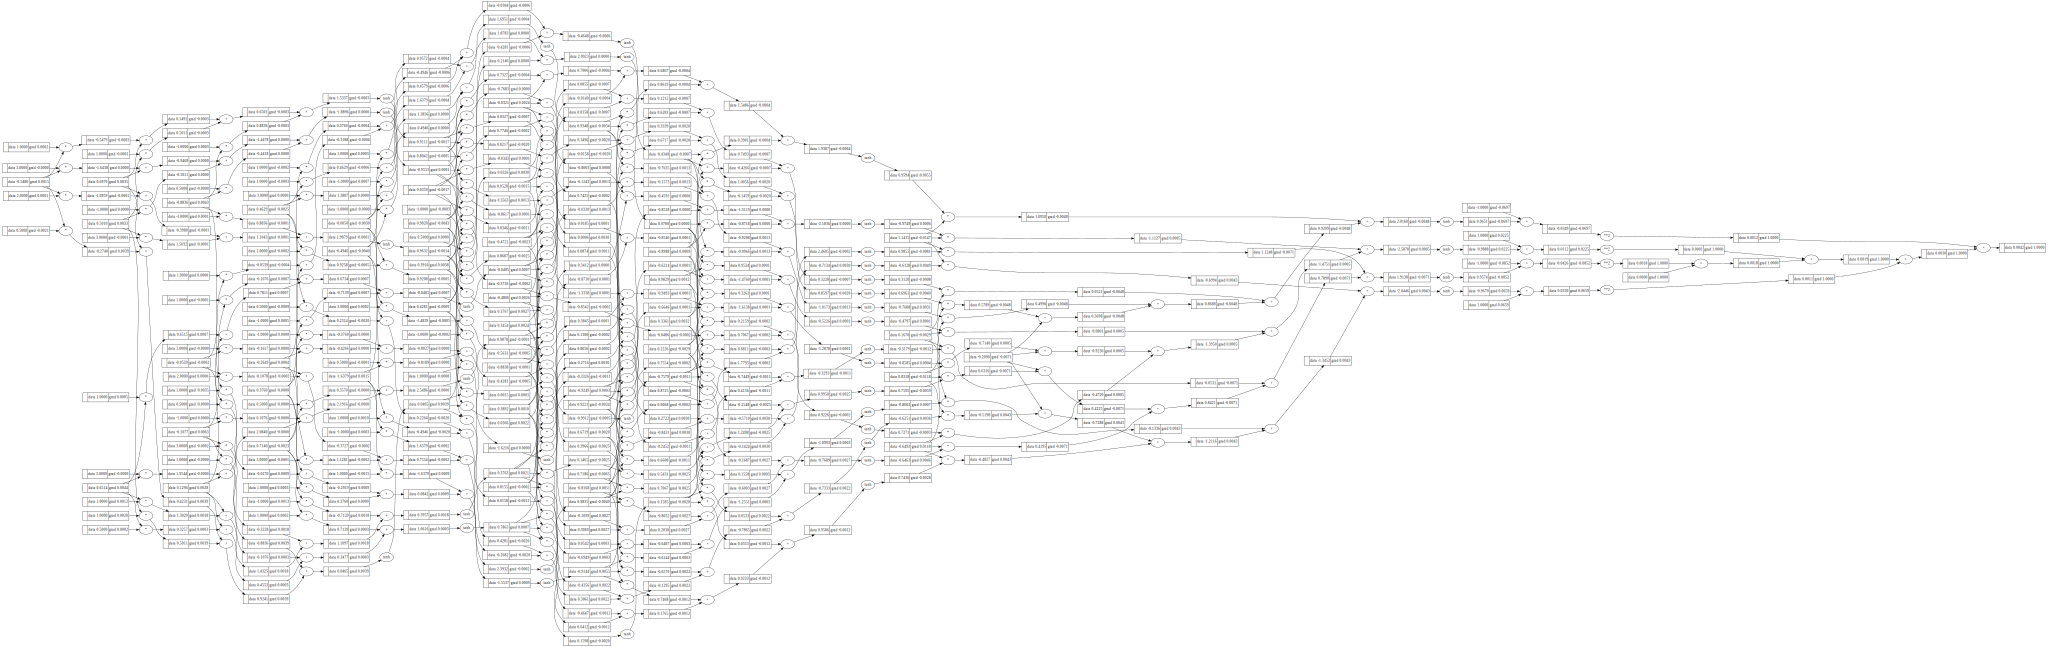

In [446]:
# Graph of 
draw_dot(loss)